In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk #a powerful library for working with human language data
from nltk.corpus import stopwords #for cleaning
from nltk.stem import LancasterStemmer ##for cleaning
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Read a data
Training data and Data Cleaning

In [3]:
train_path="/content/train_data.txt"
train_data = pd.read_csv(train_path,sep=":::",names=[
    "TITLE","GENRE","DESCRIPTION"],engine="python")

In [4]:
train_data

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
6307,"""Show de Polícia"" (2012)",reality-tv,Go to an event with large crowds is always fu...
6308,6A (2016),drama,"As if immersed in the situation, the viewer w..."
6309,Anche nel west c'era una volta Dio (1968),western,A stranger being chased by bandits dies in an...
6310,"""The Generation Gap"" (1969)",game-show,A tram of three teenagers faces off against a...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6311 entries, 1 to 6311
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        6311 non-null   object
 1   GENRE        6311 non-null   object
 2   DESCRIPTION  6311 non-null   object
dtypes: object(3)
memory usage: 197.2+ KB


In [6]:
train_data.describe(include='object').T

,count,unique,top,freq
TITLE,6311,6311,Oscar et la dame rose (2009),1
GENRE,6311,27,drama,1557
DESCRIPTION,6311,6309,"Olga, Masha, and Irina Prozoroff lead lonely ...",2


In [7]:
train_data.isnull().sum()

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [8]:
train_data.GENRE.unique() #No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

#Testing Data
And Data Cleaning

In [9]:
test_path="/content/test_data.txt"
test_data = pd.read_csv(test_path,sep=":::",names=[
    "TITLE","DESCRIPTION"],engine="python")
test_data.head()

,TITLE,DESCRIPTION
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 1 to 6531
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        6531 non-null   object
 1   DESCRIPTION  6531 non-null   object
dtypes: object(2)
memory usage: 153.1+ KB


In [11]:
test_data.describe(include='object').T

,count,unique,top,freq
TITLE,6531,6531,Edgar's Lunch (1998),1
DESCRIPTION,6531,6527,Ben Sidran presents the classic rhythm blues ...,2


In [12]:
test_data.duplicated().sum()

0

#EDA Exploratory Data Analysis

<ipython-input-13-18f4f0dd5796>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data,y="GENRE",order=


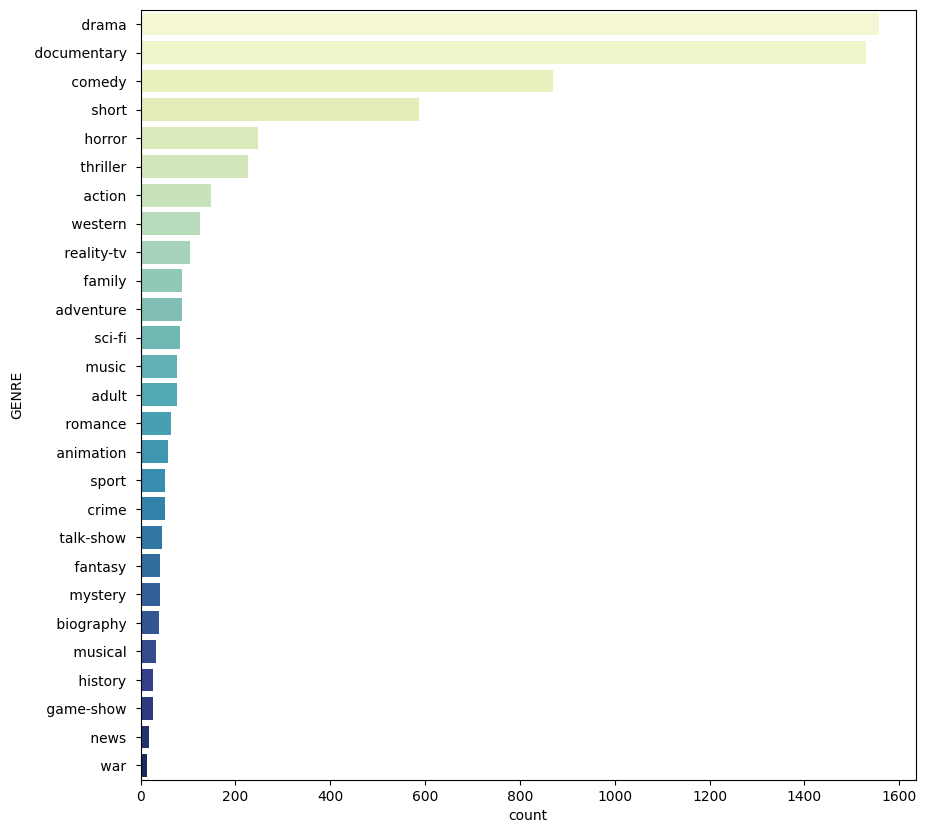

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(data=train_data,y="GENRE",order=
              train_data["GENRE"].value_counts().index,palette="YlGnBu")
plt.show()

<ipython-input-14-22541b1b7783>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x="GENRE", order=


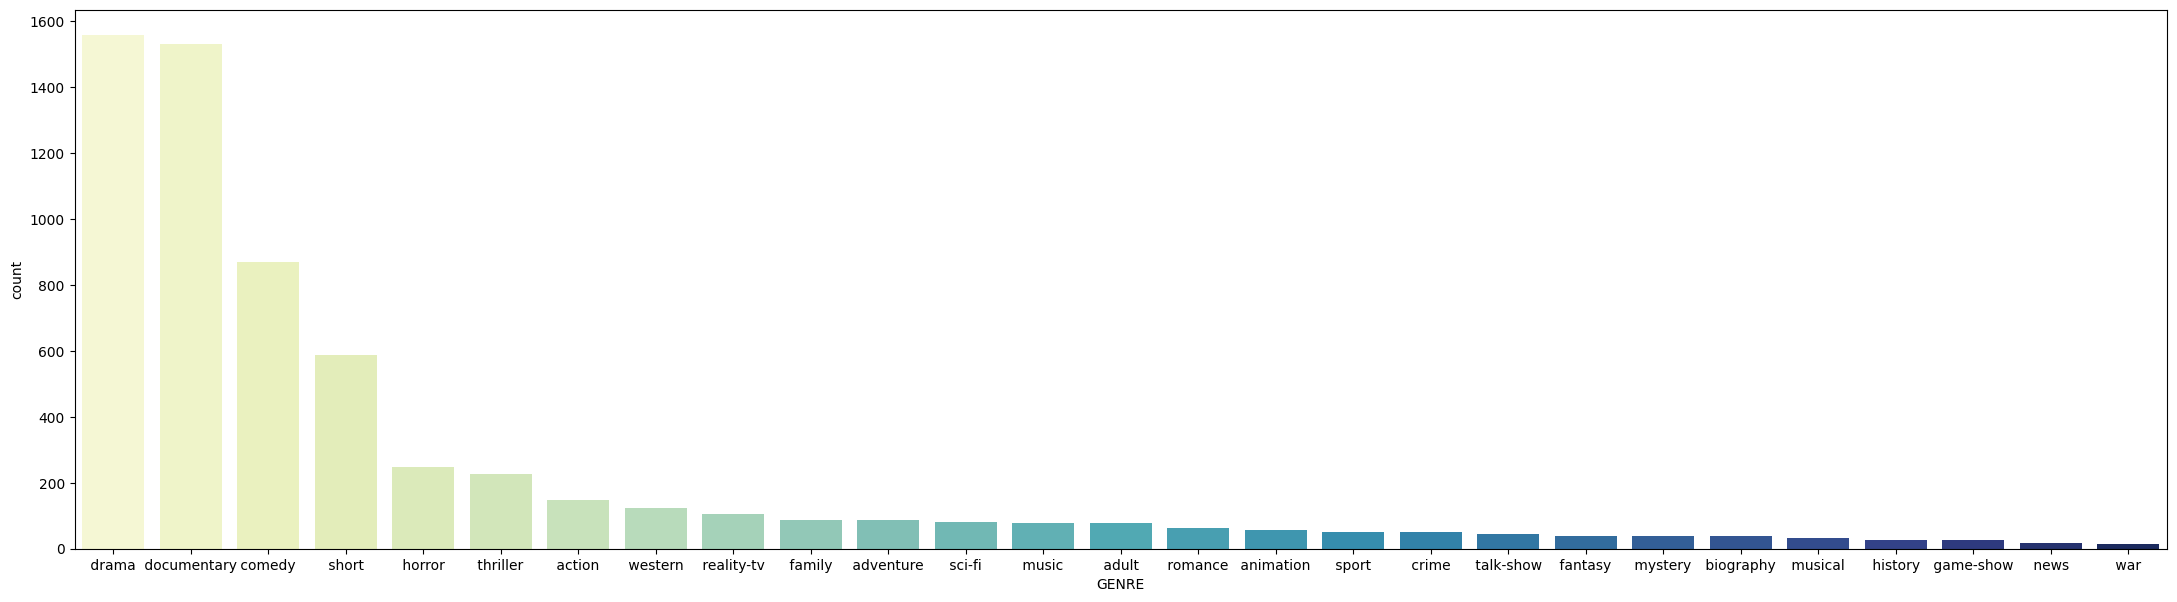

In [14]:
plt.figure(figsize=(27,7))
sns.countplot(data=train_data, x="GENRE", order=
              train_data["GENRE"].value_counts().index, palette = "YlGnBu")
plt.show()

#Data Preprocessing

In [15]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
print(train_data["DESCRIPTION"].dtypes)
print(test_data["DESCRIPTION"].dtypes)

object
object


In [17]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words("english"))  # Stopwords set

def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)  # Change to replace non-characters with a space
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    # Use the predefined stop_words variable instead of redefining it inside the function
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    return text

train_data["TextCleaning"] = train_data["DESCRIPTION"].apply(cleaning_data)
test_data["TextCleaning"] = test_data["DESCRIPTION"].apply(cleaning_data)

In [18]:
train_data

,TITLE,GENRE,DESCRIPTION,TextCleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...
...,...,...,...,...
6307,"""Show de Polícia"" (2012)",reality-tv,Go to an event with large crowds is always fu...,event large crowds always fun right exit polic...
6308,6A (2016),drama,"As if immersed in the situation, the viewer w...",immersed situation viewer witnesses distressin...
6309,Anche nel west c'era una volta Dio (1968),western,A stranger being chased by bandits dies in an...,stranger chased bandits dies accident chance h...
6310,"""The Generation Gap"" (1969)",game-show,A tram of three teenagers faces off against a...,tram three teenagers faces team three adults c...


In [19]:
test_data

,TITLE,DESCRIPTION,TextCleaning
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died spoken brother years serious cance...
5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...
...,...,...,...
6527,Posledniy den detstva (2012),Moscow suburbs. Morose and tired Seva comes h...,moscow suburbs morose tired seva comes home ni...
6528,La fracture du myocarde (1990),"Suddenly, Martin's behaviour changes radicall...",suddenly martin behaviour changes radically ta...
6529,Fun Jump (1988),Marta Boselli si reca a Pavullo per effettuar...,marta boselli reca pavullo per effettuare cors...
6530,Maanthrika Cheppu (1992),Jagadish and his friend Siddique start a vide...,jagadish friend siddique start video store tog...


Using TF-IDF to vectorize the data

In [20]:
vectorize = TfidfVectorizer()

x_train = vectorize.fit_transform(train_data["TextCleaning"])
x_test = vectorize.fit_transform(test_data["TextCleaning"])

In [21]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from time import time
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [22]:
y_test = pd.read_csv("/content/test_data_solution.txt",sep=":::",
                       usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_test.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [23]:
x = x_train
y = train_data["GENRE"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

In [34]:
NB = MultinomialNB(alpha=0.015)
start_time = time()
NB.fit(x_train,y_train)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_test,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.49406175771971494
Running Time :  0.09 Secounds


In [26]:
model = SVC()
model.fit(x_train, y_train)
model.score(x_train, y_train)


Validation Accuracy: 0.4742676167854315


In [28]:
y_pred = model.predict(x_test)
y_pred

array([' drama ', ' drama ', ' comedy ', ..., ' documentary ', ' drama ',
       ' documentary '], dtype=object)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.4742676167854315


#Other method

In [ ]:
!pip install googletrans

In [ ]:
!pip install langdetect

In [41]:
!pip install pycountry
import pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.4 MB/s eta 0:00:00


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from googletrans import Translator
from langdetect import detect
import pycountry
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [44]:
train = pd.read_csv(r"/content/train_data.txt",
                    sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [45]:
test = pd.read_csv(r"/content/test_data.txt",
                  sep=':::',names=['Title', 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [46]:
train.describe(include='object').T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [47]:
train.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [48]:
train.duplicated().sum() #No duplicates

0

In [49]:
train.Genre.unique() #No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [50]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [51]:
test.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [52]:
test.duplicated().sum() #No duplicates

0

In [53]:
train.loc[train['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [54]:
def detect_language(text):
    try:
        #Returning the name 'English instide of en'
        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train['Language'] = train['Description'].apply(detect_language)
test['Language'] = test['Description'].apply(detect_language)
train.head()

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,english
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,english
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,english
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,english
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,english


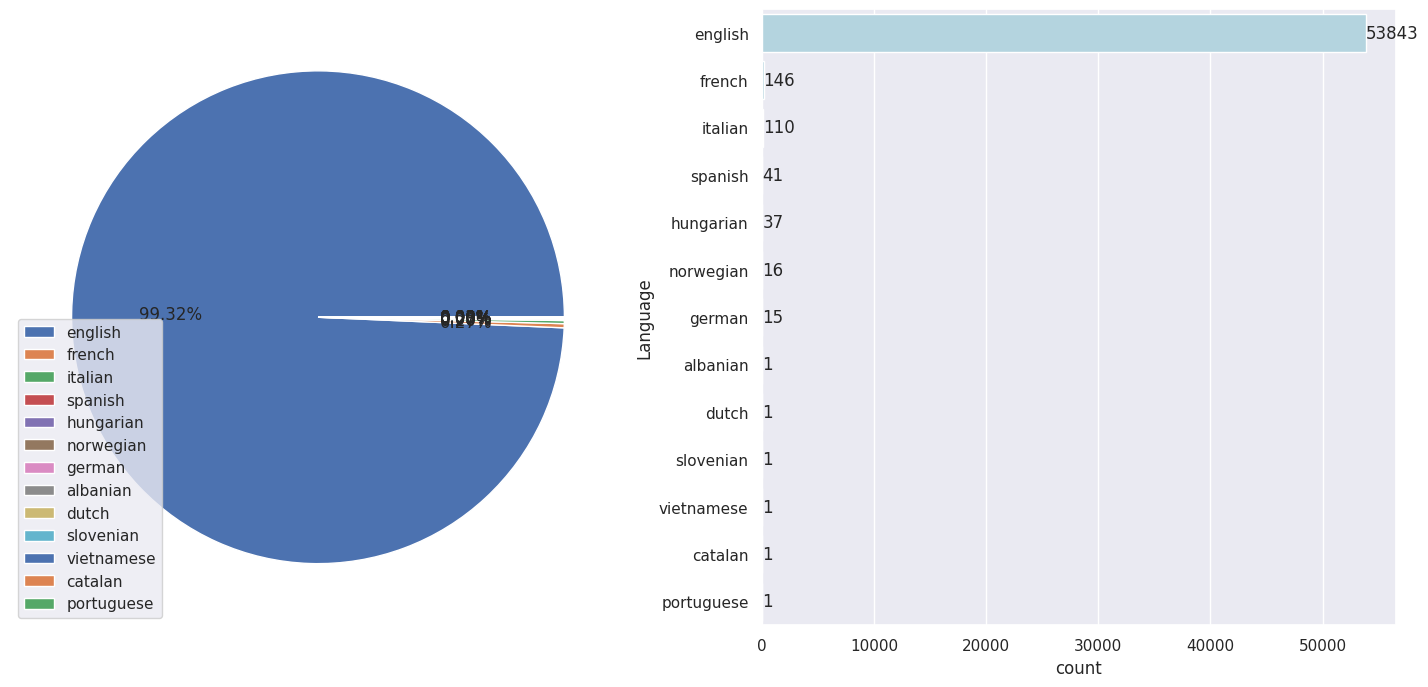

In [55]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train,y='Language',order=train.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

In [56]:
'''''
We discovered a portion of other languages in our data,
so we will handle
them later by translating them to standard language (english)
in our cleaning function
Descriptions included HTTP links
'''''

train.loc[train['Description'].str.contains(r'http\S+')].shape[0]

9

In [57]:
#For example
train.loc[train['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]
#So we need to remove them from our text

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

In [58]:
def clean_text(text):
    # Remove strange pattern in different languages if exist
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    # Remove twitter handles
    text = re.sub(r'@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub(f'[{string.punctuation}]','',text)
    # Remove numbers
    text = re.sub(f'[{string.digits}]','',text)
    # Remove single charachters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text


In [59]:
train['Description'] = train['Description'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

In [60]:
train[~train.Language.isin(['english'])]

,Title,Genre,Description,Language
210,Divorzio alla siciliana (1963),comedy,Il barone Fifě ha bisogno di un erede per ave...,italian
242,Túlvilági beszélö (1992),documentary,Tollas Tibor az os fordulatot kovetoen katona...,hungarian
282,"""Boogie-woogie 47"" (1980)",drama,En plusieurs familles de Montréal passent lé...,french
678,Pallati 176 (1986),comedy,English comedy by wellknown Albanian theater ...,albanian
806,Iszony (1965),drama,Mail to author for translation Karasz Nelli a...,hungarian
...,...,...,...,...
53697,Fantasmi e ladri (1959),comedy,Annunziata ha letto diecimila gialli spopola ...,italian
53712,Due notti con Cleopatra (1954),comedy,Cleopatra č una donna bellissima ma ha un pic...,italian
53878,Gyilkos kedv (1997),drama,Kora delutan egy iskolabol hazatero kislany c...,hungarian
54165,Az áldozat (1994),documentary,Mail author for translation Az os forradalom ...,hungarian


In [61]:
#Translate other languages
def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train.loc[~train['Language'].isin(['english']), 'Description']=train.loc[~train['Language'].isin(['english']),'Description'].apply(trans)
test.loc[~test['Language'].isin(['english']), 'Description']=test.loc[~test['Language'].isin(['english']),'Description'].apply(trans)

In [62]:
train.drop(columns='Language',inplace=True)
test.drop(columns='Language',inplace=True)

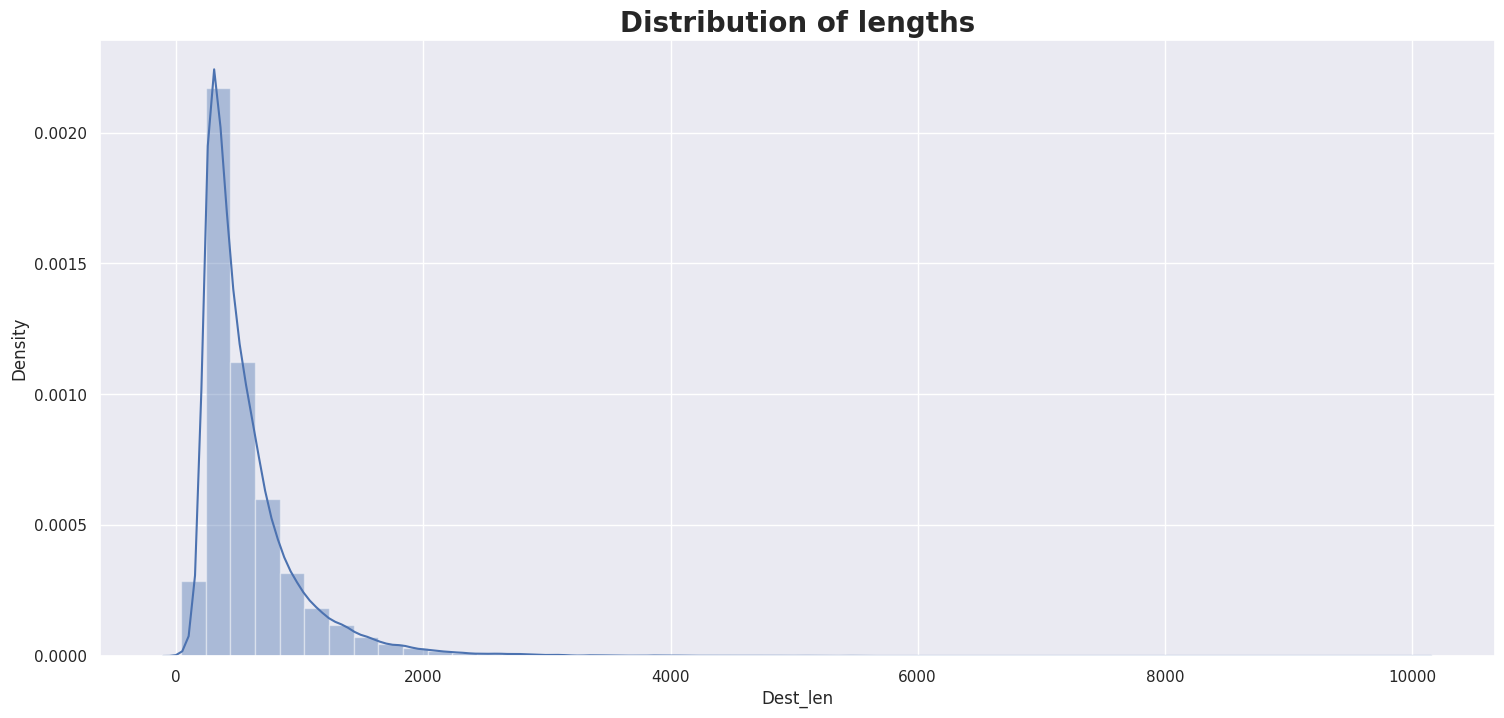

In [63]:
#Distribution of text lengths
train['Dest_len'] = train['Description'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()

In [64]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                                   ngram_range=(1,1), #Capture only single words in each text(unigrams)
                                   stop_words='english',#Remove stop_words
                                   min_df=2)#Ignore words that appears less than 2 times
x_train = tfidf_vectorizer.fit_transform(train['Description'])
x_test = tfidf_vectorizer.transform(test['Description'])

In [65]:
sampler = RandomOverSampler()
#We will pass to it the output of TfidfVectorizer from train data
x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['Genre'])

In [66]:
print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [67]:
y_actual = pd.read_csv(r"/content/test_data_solution.txt",
                      sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [68]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5446678966789668
Running Time :  3.23 Secounds


In [69]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.36      0.48      0.41      1314
       adult        0.49      0.52      0.51       590
   adventure        0.33      0.25      0.28       775
   animation        0.31      0.23      0.26       498
   biography        0.04      0.03      0.03       264
      comedy        0.58      0.53      0.55      7446
       crime        0.16      0.17      0.17       505
 documentary        0.72      0.72      0.72     13096
       drama        0.64      0.56      0.60     13612
      family        0.26      0.22      0.24       783
     fantasy        0.17      0.15      0.16       322
   game-show        0.77      0.67      0.72       193
     history        0.09      0.06      0.07       243
      horror        0.52      0.68      0.59      2204
       music        0.40      0.72      0.51       731
     musical        0.19      0.10      0.13       276
     mystery        0.15      0.08      0.11       318
        n

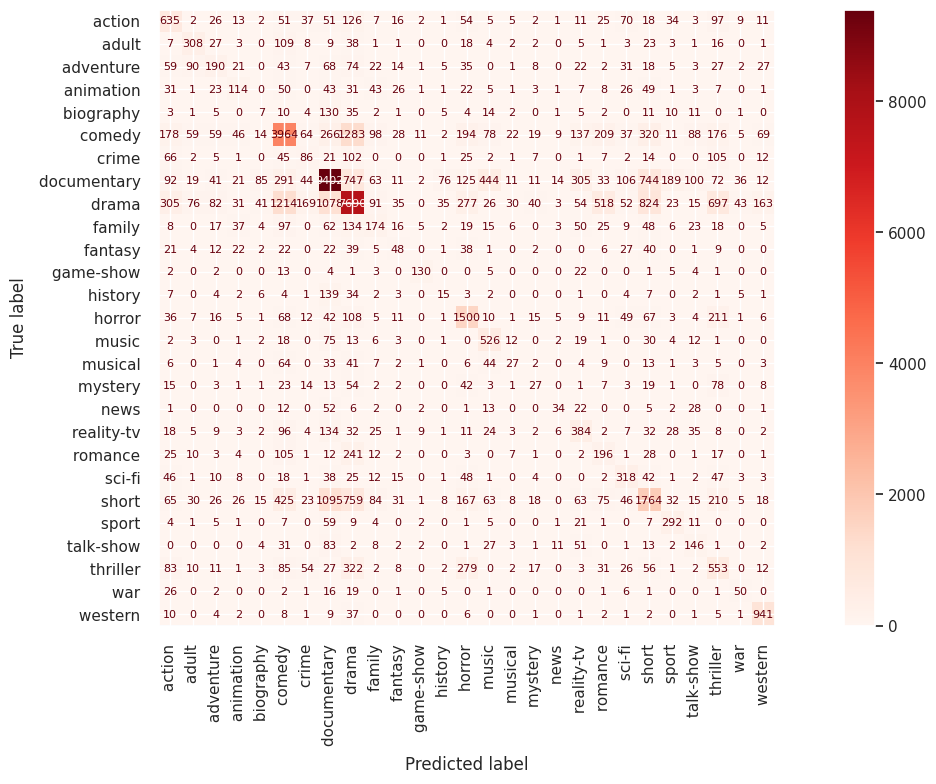

In [70]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [71]:
pd.concat([pd.concat([test,y_actual],axis=1),pd.Series(y_pred)],axis
          =1).rename(columns={0:'Predicted_Genre'}).head(10)

,Title,Description,Actual_Genre,Predicted_Genre
0,Edgar's Lunch (1998),LR Brane loves his life his car his apartmen...,thriller,short
1,La guerra de papá (1977),Spain March Quico is very naughty child of t...,comedy,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,Meu Amigo Hindu (2015),His father has died he hasnt spoken with his ...,drama,drama
4,Er nu zhai (1955),Before he was known internationally as martia...,drama,action
5,Riddle Room (2016),Emily Burns is being held captive in room wit...,horror,thriller
6,L'amica (1969),The beautiful but neglected wife of brilliant...,drama,drama
7,Ina Mina Dika (1989),Vasu Inamdar Ina suffers from disorder where ...,comedy,comedy
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,Press (2011),Press is story of young people overwhelmed by...,drama,short


In [72]:
y_train_modified = train['Genre'].apply(lambda genre: genre
                                        if genre.strip() in ['drama','documentary']
                                        else 'other')
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre:
                                                   genre if genre.strip() in ['drama','documentary']
                                                   else 'other')

In [73]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.6947416974169742
Running Time :  0.36 Secounds
